In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re
import string

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ocean-modelC/Data/final_myPersonality.csv')
df.head()

,Unnamed: 0,STATUS,cEXT,cNEU,cAGR,cCON,cOPN
0,0,likes sound thunder.,0,1,0,0,1
1,1,sleepy even funny get sleep.,0,1,0,0,1
2,2,sore wants knot muscles base neck stop hurting...,0,1,0,0,1
3,3,likes day sounds new song.,0,1,0,0,1
4,4,home. happy face smiley,0,1,0,0,1


In [ ]:
df['cAGR'].value_counts()

1    5266
0    4638
Name: cAGR, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


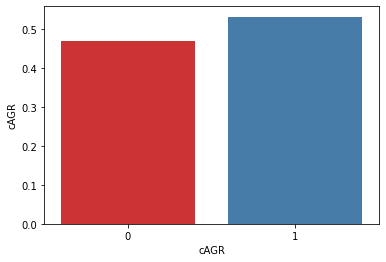

In [ ]:
import seaborn as sns

sns.barplot(df['cAGR'], df['cAGR'], palette='Set1', estimator=lambda x: len(x) / len(df) )

In [ ]:
df['cAGR'] = df['cAGR'].astype('category')
dataframe = df[['STATUS', 'cAGR']]
dataframe.head()

,STATUS,cAGR
0,likes sound thunder.,0
1,sleepy even funny get sleep.,0
2,sore wants knot muscles base neck stop hurting...,0
3,likes day sounds new song.,0
4,home. happy face smiley,0


In [ ]:
val_dataframe = dataframe.sample(frac = 0.1, random_state = 10)
train_dataframe = dataframe.drop(val_dataframe.index)
val_data, val_labels, train_data, train_labels = val_dataframe['STATUS'], val_dataframe['cAGR'], train_dataframe['STATUS'], train_dataframe['cAGR']
print("Training Samples => ",len(train_dataframe)," Validation Samples => ",len(val_dataframe))

Training Samples =>  8914  Validation Samples =>  990


In [ ]:
class_names = ['n', 'y']

In [ ]:
vectorizer = TextVectorization(standardize = "lower_and_strip_punctuation",
                               max_tokens = 20000, 
                               output_sequence_length = 300,
                               output_mode='int')

train_ds = tf.data.Dataset.from_tensor_slices(train_data).batch(64)
vectorizer.adapt(train_ds)

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
path_to_glove_file = '/content/drive/MyDrive/ocean-modelC/Data/glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 12437 words (3949 misses)


In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    trainable = False,
)

In [ ]:
from tensorflow.keras import layers
xavier =  tf.keras.initializers.GlorotNormal()

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.LSTM(64, dropout = 0.22))(embedded_sequences)
x = layers.Dense(8, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.22)(x)

predictions = layers.Dense(2, activation="softmax", name="predictions")(x)
model = tf.keras.Model(int_sequences_input, predictions)

model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_9 (Embedding)      (None, None, 100)         1638800   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 1032      
_________________________________________________________________
batch_normalization_9 (Batch (None, 8)                 32        
_________________________________________________________________
dropout_9 (Dropout)          (None, 8)                 0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 18 

In [ ]:
X_train = vectorizer(np.array([[s] for s in train_data])).numpy()
X_val = vectorizer(np.array([[s] for s in val_data])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [ ]:
from sklearn.utils import compute_class_weight

classWeight = compute_class_weight('balanced', [0,1], df['cAGR']) 
classWeight = dict(enumerate(classWeight))
print(classWeight)

{0: 1.0677015955153084, 1: 0.9403721990125332}


In [ ]:
rms = tf.keras.optimizers.RMSprop(learning_rate=5*1e-5, rho=0.85, momentum=0.25, epsilon=1e-06)

model.compile(loss = "sparse_categorical_crossentropy", optimizer = rms, metrics = ["acc"])

history = model.fit(X_train, y_train, batch_size = 128, epochs = 40, validation_data = (X_val, y_val), class_weight=classWeight)

Epoch 1/40
70/70 [==============================] - 6s 54ms/step - loss: 0.9858 - acc: 0.5040 - val_loss: 0.6879 - val_acc: 0.5455
Epoch 2/40
70/70 [==============================] - 3s 37ms/step - loss: 0.8514 - acc: 0.5032 - val_loss: 0.6907 - val_acc: 0.5253
Epoch 3/40
70/70 [==============================] - 3s 37ms/step - loss: 0.7835 - acc: 0.5120 - val_loss: 0.6947 - val_acc: 0.5172
Epoch 4/40
70/70 [==============================] - 3s 37ms/step - loss: 0.7563 - acc: 0.5228 - val_loss: 0.6988 - val_acc: 0.5182
Epoch 5/40
70/70 [==============================] - 3s 37ms/step - loss: 0.7465 - acc: 0.5274 - val_loss: 0.7049 - val_acc: 0.5121
Epoch 6/40
70/70 [==============================] - 3s 37ms/step - loss: 0.7271 - acc: 0.5202 - val_loss: 0.7097 - val_acc: 0.5061
Epoch 7/40
70/70 [==============================] - 3s 37ms/step - loss: 0.7264 - acc: 0.5203 - val_loss: 0.7101 - val_acc: 0.5152
Epoch 8/40
70/70 [==============================] - 3s 38ms/step - loss: 0.7210 - a

In [ ]:
score, acc = model.evaluate(x=(X_val), y=(y_val))
print('Test score:', score)
print('Test accuracy:', acc)

31/31 [==============================] - 0s 12ms/step - loss: 0.6894 - acc: 0.5404
Test score: 0.6893985271453857
Test accuracy: 0.5404040217399597


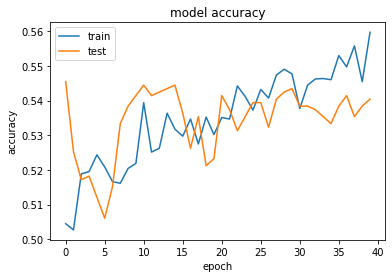

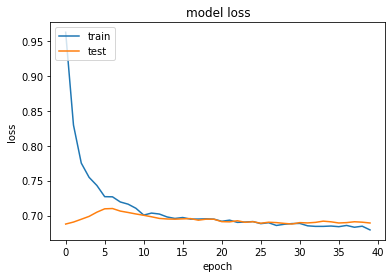

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred))

Confusion Matrix
[[252 197]
 [258 283]]


In [ ]:
print('Classification Report')
target_names = class_names
print(classification_report(y_val, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           n       0.49      0.56      0.53       449
           y       0.59      0.52      0.55       541

    accuracy                           0.54       990
   macro avg       0.54      0.54      0.54       990
weighted avg       0.55      0.54      0.54       990



In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [["I  love new experiences"]]
)

class_names[np.argmax(probabilities[0])]

'y'

In [ ]:
rms = tf.keras.optimizers.RMSprop(learning_rate=5*1e-5, rho=0.85, momentum=0.25, epsilon=1e-06)
end_to_end_model.compile(loss = "sparse_categorical_crossentropy", optimizer = rms, metrics = ["acc"])

In [ ]:
end_to_end_model.save('/content/drive/MyDrive/ocean-modelC/Models/ANewModel_54_55', save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ocean-modelC/Models/ANewModel_54_55/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ocean-modelC/Models/ANewModel_54_55/assets


In [ ]:
Amodel = keras.models.load_model('/content/drive/MyDrive/ocean-modelC/Models/ANewModel_54_55')

In [ ]:
print(class_names[np.argmax(Amodel.predict([['I like new experiences']]))])

y
